In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit

from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..'))

sys.path.append(project_root)

from Early_predict_UQ.data.make_dataset import make_data

def plot_over_time(w_times, class_balance, onset, scores_windows = None, confidence_windows = None):
    plt.figure()
    if (scores_windows != None):
        plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
        plt.axvline(onset, linestyle="--", color="k", label="Onset")
        plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
        plt.xlabel("time (s)")
        plt.ylabel("classification accuracy")
        plt.title("Classification score over time")
        plt.legend(loc="lower right")
        plt.show()
    if (confidence_windows != None):
        plt.plot(w_times, np.mean(confidence_windows, 0), label="Score")
        plt.axvline(onset, linestyle="--", color="k", label="Onset")
        plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
        plt.xlabel("time (s)")
        plt.ylabel("confidence")
        plt.title("Classification score over time")
        plt.legend(loc="lower right")
        plt.show()


subject_list = [1]
# Preprocessed epochs
epochs, labels = make_data(subject_list)
#epochs.plot()
#print("epochs shape: ",epochs.shape)
#print("labels shape: ",labels.shape)


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
Choosing from all possible events


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


In [ ]:
def calculate_entropy(probabilities):
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy
def find_mean_probabilities(probabilities):
   return np.mean(probabilities, axis=0)

# Calculate maximum probability
def calculate_max_mean_probability_and_class(probabilities):
    max_mean_probability_index = np.argmax(np.mean(probabilities, axis=0))
    max_mean_probability = np.max(np.mean(probabilities, axis=0))
    corresponding_class = max_mean_probability_index + 1  # Classes are typically indexed starting from 1
    return max_mean_probability, corresponding_class

def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

threshold = 0.7


# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
print("len of epochs data:\n",len(epochs_data))
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
print("cv split: \n", cv_split)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a sliding window

w_length = int(sfreq * 0.5)  # Window length
w_step = int(sfreq * 0.1)  # window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) # Set of starting positions in the signal(Note! the signal is 2s to 4s) 
#if len=0.5 and step = 0.1. Theres 36 starting points 0.1 s apart, multiplied by the sfreq
print("w start shape: ", w_start.shape)
print("w start: \n", w_start)
scores_windows = []  

#threshold = 0.5
confidence_windows = []
counter = 0
# Running classification across the signal
for train_idx, test_idx in cv_split:
    print("train idx: ", train_idx)
    print("test idx: ", test_idx)
    print("nr train_index:", len(train_idx))
    print("nr test_index:", len(test_idx))
    counter +=1
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx]) #  why define it here!

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin


    #FIX THE STUFF LOL, IM TOO TIRED TO MAKE A PLAN 4 U BABES <33 LOVE U
    # Test the classifier on the windows. This is where we run over the signal
    score_this_window = []
    confidence_this_window = []
    max_classes = []
    num = 1
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
        probabilities = lda.predict_proba(X_test)
        print("prob shape: ", probabilities.shape)
        #print("probabilities: \n", probabilities)

        #print("prob means of the classes: \n ", find_mean_probabilities(probabilities))
        mean_probs = find_mean_probabilities(probabilities)

        #entropy = calculate_entropy(probabilities)
       
        confidence_this_window.append(mean_probs)

    #most_freq_max_class = most_frequent(max_classes)
    
    # Plot confidence 
    plt.plot(w_times, confidence_this_window, label = ["1","2","3","4"])
    plt.plot
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.title("Classification Confidence over Time")
    plt.legend()
    plt.show()
    scores_windows.append(score_this_window)
    #print("right label:", y_test[?])
    if counter == 2:
        break

    '''plt.plot(w_times,mean_confidence_class_1, label="Confidence Class 1")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.xlabel("time (s)")
    plt.ylabel("confidence")
    plt.title("Classification confidence over time")
    plt.legend(loc="lower right")
    plt.show()'''
   
    
# Plot the scores over time
#plot_over_time(w_times, class_balance, epochs.tmin, scores_windows, confidence_windows)

<h2> Tests on a single epoch

Choosing from all possible events


Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
shape of epochs data:
 (576, 22, 1001)
cv split: 
 <generator object BaseShuffleSplit.split at 0x7f54eaabc540>
w start shape:  (36,)
nr train_index: 460
nr test_index: 116
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

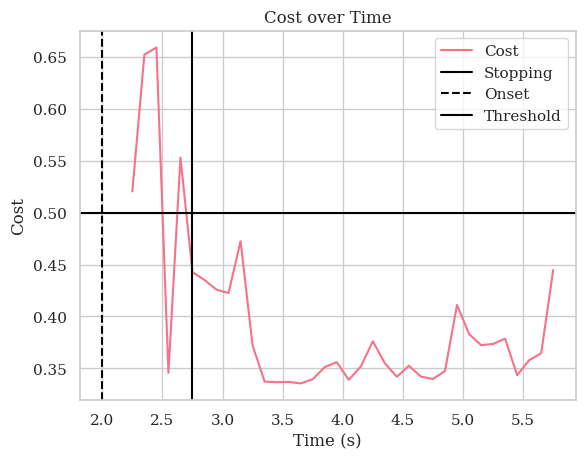

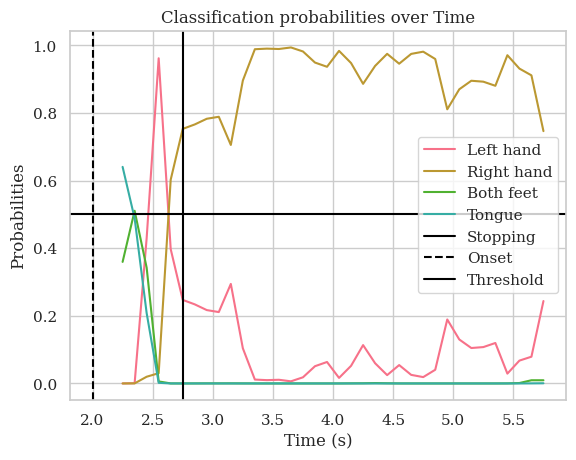

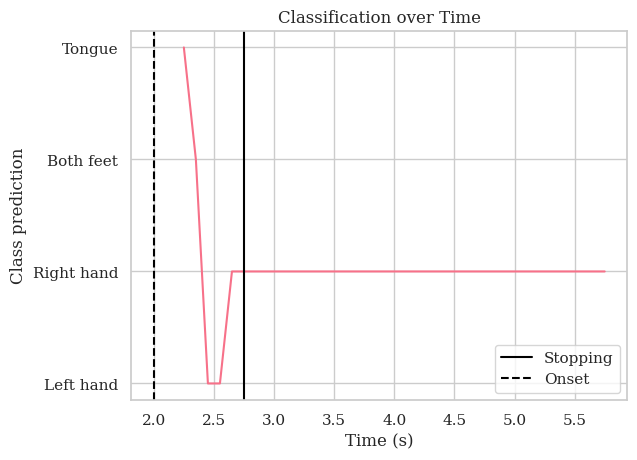

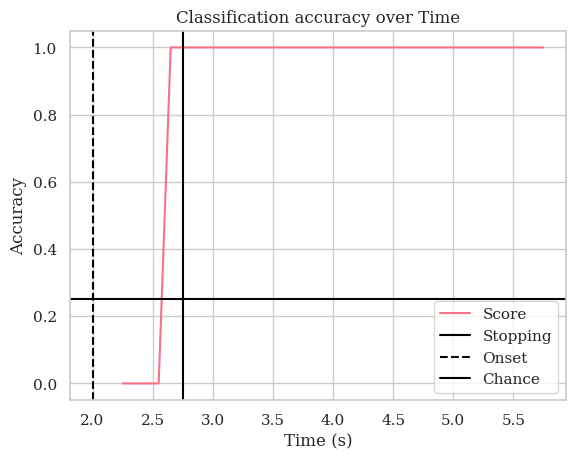

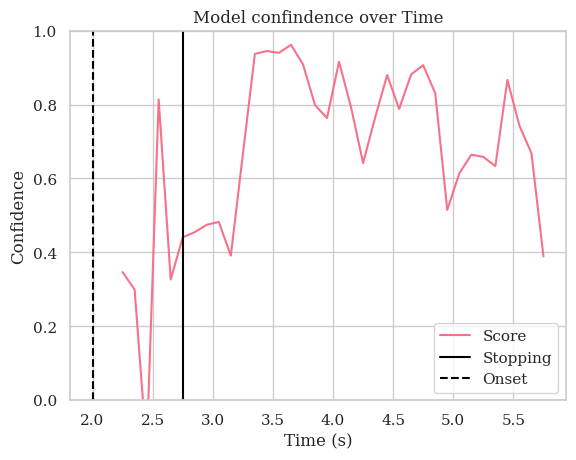

right label: Right hand


In [4]:

#Want to look at 1 epoch only, not all epochs in the test idx at the given sliding window
import scipy
from scipy.stats import entropy

def calculate_max_mean_probability_and_class(probabilities):
    k = 2
    np.sort(np.argpartition(probabilities, len(probabilities) - k)[-k:])
    return max_mean_probability, corresponding_class

threshold = 0.7

subject_list = [1] # Choosing the subject or subjects
# Preprocessed epochs
epochs, labels = make_data(subject_list)
# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
print("shape of epochs data:\n",epochs_data.shape)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
print("cv split: \n", cv_split)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False) # why 4 components or 5

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a sliding window
w_length = int(sfreq * 0.5)  # Window length
w_step = int(sfreq * 0.1)  # window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) # Set of starting positions in the signal(Note! the signal is 2s to 4s) 
#if len=0.5 and step = 0.1. Theres 36 starting points 0.1 s apart, multiplied by the sfreq
print("w start shape: ", w_start.shape)
#print("w start: \n", w_start)
scores_windows = [] 
#threshold = 0.5
entropy_windows = []
# Running classification across the signal
for train_idx, test_idx in cv_split:
    #print("train idx: ", train_idx)
    #print("test idx: ", test_idx)
    print("nr train_index:", len(train_idx))
    print("nr test_index:", len(test_idx))
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx]) #  why define and transform it here, and then do it later as well!

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

    # Test the classifier on the windows. This is where we run over the signal
    preds_this_window = []
    probs_this_window = []
    score_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    costs = []

    chosen_epoch = 80 #Choose an epoch between 1 and 116. As the testset is 20% 116 epochs of the whole data 576 epochs
    predict = False
    predict_time = 0
    numberOfNs = 0
    numTimesBelowThreshold = 0
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)]) #-it chooses all epochs and all channels, and a subset of the dataopoint. Then applied CSP transformation
        print("X_test  shape:\n",X_test.shape)
        X_test_1_epoch = X_test[chosen_epoch] #Chooosing a specific epoch in the test set 
        print("X_test_1_epoch shape:\n", X_test_1_epoch.shape)

        #Accuracy
        score = lda.score(X_test_1_epoch.reshape(1, -1), [y_test[chosen_epoch]])
        score_this_window.append(score)
        
        probabilities = lda.predict_proba([X_test_1_epoch])
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

        prediction = lda.predict([X_test_1_epoch])
        preds_this_window.append(prediction)

        print("Prediction for this time window: ", prediction+4)
        print("prob shape: ", probabilities.shape)
        print("probabilities: \n", probabilities)


        #predictive entropy - H_pred(p) 
        entropy_score = entropy(probabilities, axis = 1) #- see if entropy is better than probabilites
        entropy_this_window.append(entropy_score)

        '''
        Confidence - as seen in: 
        Uncertainty Quantification in Machine Learning for Biosignal Applications - A Review, page 13.
        1 - H_pred(p) can be used as a confidence measure. 
        '''
        #confidence
        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)
        #cost function
        probabilities = np.array(probabilities)
        probabilities = probabilities.flatten()
        sorted_probs = sorted(probabilities, reverse=True)
        print("sorted probabilities: \n", sorted_probs)
        #cost1 = 1/(1+(sorted_probs[0] - sorted_probs[1]))
        cost =1/(1+(sorted_probs[0] + (sorted_probs[0] - sorted_probs[1])))
        costs.append(cost)
        if cost < 0.5 and predict == False:
            numTimesBelowThreshold +=1
            if numTimesBelowThreshold == 2:
                predict = True
                predict_time = numberOfNs
                print("BELOW")
        numberOfNs+=1
                



    class_names = {
        1: "Left hand",
        2: "Right hand",
        3: "Both feet",
        4: "Tongue"
    }
    print("len w-times: ", w_times)
    print("len w-start: ", w_start)
    print("len w-times[:numberOfNs]: ", w_times[:numberOfNs])
    print("len w-start[:numberOfNs]: ", w_start[:numberOfNs])
    print("number n's ", numberOfNs)
    ##Costs for each of the classes for each window
    plt.plot(w_times, costs, label='Cost')
    plt.xlabel("Time (s)")
    plt.ylabel("Cost")
    plt.axvline(w_times[predict_time], linestyle="-", color="k", label="Stopping")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.title("Cost over Time")
    plt.legend()
    plt.show()

    ##Probabiltiies for each of the classes for each window
    plt.plot(w_times, probs_this_window, label=[class_names[label] for label in [1, 2, 3, 4]])
    plt.xlabel("Time (s)")
    plt.ylabel("Probabilities")
    plt.axvline(w_times[predict_time], linestyle="-", color="k", label="Stopping")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.title("Classification probabilities over Time")
    plt.legend()
    plt.show()

    ##Predictions for each window
    preds_this_window_plottable = [x+4 for x in preds_this_window]
    plt.plot(w_times, preds_this_window_plottable)
    plt.xlabel("Time (s)")
    plt.ylabel("Class prediction")
    plt.axvline(w_times[predict_time], linestyle="-", color="k", label="Stopping")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.title("Classification over Time")
    plt.yticks([1, 2, 3, 4], [class_names[label] for label in [1, 2, 3, 4]])
    plt.legend(loc="lower right")
    plt.show()
    plt.show()

    ##Accuracy for each window
    plt.plot(w_times, score_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy")
    plt.axvline(w_times[predict_time], linestyle="-", color="k", label="Stopping")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
    plt.title("Classification accuracy over Time")
    plt.legend()
    plt.show()

    plt.plot(w_times, confidence_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.ylim(0,1)
    plt.axvline(w_times[predict_time], linestyle="-", color="k", label="Stopping")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    #plt.axhline(threshold, linestyle="-", color="k", label="Threshold")
    plt.title("Model confindence over Time")
    plt.legend()
    plt.show()

    '''entropy = np.array(entropy_this_window)
    entropy =  entropy.flatten()
    benefit = np.subtract(w_times, entropy )
    plt.plot(w_times,  benefit, label="Benefit")
    plt.xlabel("Time (s)")
    plt.ylabel("Benefit")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    #plt.axhline(threshold, linestyle="-", color="k", label="Threshold")
    plt.title("Model benefit over Time")
    plt.legend()
    plt.show()'''


    y_test = y_test+4
    print("right label:", class_names[y_test[chosen_epoch]])
    break


<h2>Increasing window instead

In [ ]:

#Want to look at 1 epoch only, not all epochs in the test idx at the given sliding window
import scipy
from scipy.stats import entropy

def calculate_entropy(probabilities):
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def find_mean_probabilities(probabilities):
   return np.mean(probabilities, axis=0)

def calculate_max_mean_probability_and_class(probabilities):
    max_mean_probability_index = np.argmax(np.mean(probabilities, axis=0))
    max_mean_probability = np.max(np.mean(probabilities, axis=0))
    corresponding_class = max_mean_probability_index + 1  # Classes are typically indexed starting from 1
    return max_mean_probability, corresponding_class

def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

threshold = 0.7

subject_list = [1] # Choosing the subject or subjects
# Preprocessed epochs
epochs, labels = make_data(subject_list)
# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
print("shape of epochs data:\n",epochs_data.shape)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
print("cv split: \n", cv_split)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False) # why 4 components or 5

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a growing window
# Define initial window parameters
initial_window_length = int(sfreq * 0.5)  # Initial window length
w_step = int(sfreq * 0.1)  # Window step size
w_start = np.arange(0, epochs_data.shape[2] - initial_window_length, w_step)  # Set of starting positions in the signal (Note! the signal is 2s to 4s)

print("w start shape: ", w_start.shape)
#print("w start: \n", w_start)
scores_windows = [] 
#threshold = 0.5
entropy_windows = []
# Running classification across the signal
for train_idx, test_idx in cv_split:
    #print("train idx: ", train_idx)
    #print("test idx: ", test_idx)
    print("nr train_index:", len(train_idx))
    print("nr test_index:", len(test_idx))
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx]) #  why define and transform it here, and then do it later as well!

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin



    # Test the classifier on the windows. This is where we run over the signal
    preds_this_window = []
    probs_this_window = []
    score_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    chosen_epoch = 18 #Choose an epoch between 1 and 116. As the testset is 20% 116 epochs of the whole data 576 epochs
    for n, window_start in enumerate(w_start):
        window_length = initial_window_length + n * w_step
        X_test  = csp.transform(epochs_data[test_idx][:, :, window_start:(window_start + window_length)])
        print("X_test  shape:\n",X_test.shape)
        X_test_1_epoch = X_test [chosen_epoch] #Chooosing a specific epoch in the test set 
        print("X_test_1_epoch shape:\n", X_test_1_epoch.shape)

        #Accuracy
        score = lda.score(X_test_1_epoch.reshape(1, -1), [y_test[chosen_epoch]])
        score_this_window.append(score)
        
        probabilities = lda.predict_proba([X_test_1_epoch])
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

        prediction = lda.predict([X_test_1_epoch])
        preds_this_window.append(prediction)

        print("Prediction for this time window: ", prediction)
        print("prob shape: ", probabilities.shape)
        print("probabilities: \n", probabilities)

        #predictive entropy - H_pred(p) 
        entropy_score = entropy(probabilities, axis = 1) #- see if entropy is better than probabilites
        entropy_this_window.append(entropy_score)

        '''
        Confidence - as seen in: 
        Uncertainty Quantification in Machine Learning for Biosignal Applications - A Review, page 13.
        1 - H_pred(p) can be used as a confidence measure. Normalizing seems useful - 1 / (1- entropy-score)
        '''
        #confidence
        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)

    class_names = {
        1: "Left hand",
        2: "Right hand",
        3: "Both feet",
        4: "Tongue"
    }

    ##Probabiltiies for each of the classes for each window
    plt.plot(w_times, probs_this_window, label=[class_names[label] for label in [1, 2, 3, 4]])
    plt.xlabel("Time (s)")
    plt.ylabel("Probabilities")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.title("Classification probabilities over Time")
    plt.legend()
    plt.show()

    ##Predictions for each window
    preds_this_window_plottable = [x+4 for x in preds_this_window]
    plt.plot(w_times, preds_this_window_plottable)
    plt.xlabel("Time (s)")
    plt.ylabel("Class prediction")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.title("Classification over Time")
    plt.yticks([1, 2, 3, 4], [class_names[label] for label in [1, 2, 3, 4]])
    plt.legend(loc="lower right")
    plt.show()
    plt.show()

    ##Accuracy for each window
    plt.plot(w_times, score_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
    plt.title("Classification accuracy over Time")
    plt.legend()
    plt.show()

    ##Entropy for each window 
    plt.plot(w_times, entropy_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Entropy ")
    plt.ylim(0,1)
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.title("Model entropy over Time")
    plt.legend()
    plt.show()

    plt.plot(w_times, confidence_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.ylim(0,1)
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    #plt.axhline(threshold, linestyle="-", color="k", label="Threshold")
    plt.title("Model confidence over Time")
    plt.legend()
    plt.show()


    y_test = y_test+4
    print("right label:", class_names[y_test[chosen_epoch]])
    break
   
